# Plotting the Map of average sqrt(V2) for the RYF experiment under .1 resolution

**Requirements:** The `conda/analysis3-22.07` (or later) module on the OOD or Gadi (or your own up-to-date cookbook installation).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import os
import xarray as xr
import numpy as np
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cosima_cookbook as cc
session = cc.database.create_session()

In [2]:
from dask.distributed import Client
client = Client(n_workers=os.cpu_count()-2, threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33791,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:36691,Total threads: 1
Dashboard: /proxy/34887/status,Memory: 35.97 GiB
Nanny: tcp://127.0.0.1:46079,


I will use the "01deg_jra55v13_ryf9091" experiment (Access-om2-01, repeated year forcing for the early 90's, forced with JRA atmospheric reanalysis)

In [3]:
vvars = cc.querying.get_variables(session, experiment='01deg_jra55v13_ryf9091')
vvars[vvars['name'].str.lower().str.contains('hu')]

#There is no dzu. SO I have to either regrid dzt into u, or find another way to do iit
#Ocean.nc contains monthly u,v, has each netcdf containing 3 months 
#of monthly data (nt=3). I want to get the last 20 yrs for a climatology. (Ideally would
# be 30, but I think that would crash). That means I need 20*4 = last 80 netcdfs

,name,long_name,units,frequency,ncfile,cell_methods,# ncfiles,time_start,time_end
422,hu,ocean depth on u-cells,m,static,output1115/ocean/ocean_grid.nc,time: point,1164,1900-04-01 00:00:00,2180-01-01 00:00:00


In [4]:
#Getting variables
#variable = 'uvel'
experiment = '01deg_jra55v13_ryf9091'
UVEL = cc.querying.getvar(experiment, 'u' , session, frequency='1 monthly', n=-40)
UVEL = UVEL.isel({'yu_ocean': slice(0, 494)}).isel({'st_ocean': slice(0, 40)})# First 500 m
VVEL = cc.querying.getvar(experiment, 'v' , session, frequency='1 monthly',n=-40)
VVEL = VVEL.isel({'yu_ocean': slice(0, 494)}).isel({'st_ocean': slice(0, 40)})
dzt = cc.querying.getvar(experiment, 'dzt' , session, frequency='1 monthly',n=-40)
dzt = dzt.isel({'yt_ocean': slice(0, 494)}).isel({'st_ocean': slice(0, 40)})
# To minimize computational efforts you can....
      # Set ylim to get only the Southermost Latitudes of the Southern Ocean (Lets say south of 60S)
      # Set a depth limit too.. perhaps 1000m or 500 m
      #When I calculate the mean it has to be a weighted mean against dzt

In [5]:
#Load the bathymetry
hu = cc.querying.getvar(experiment, 'hu', session, n=1).drop(['geolat_c', 'geolon_c']).isel({'yu_ocean': slice(0, 494)})
hu

<xarray.DataArray 'hu' (yu_ocean: 494, xu_ocean: 3600)>
dask.array<getitem, shape=(494, 3600), dtype=float32, chunksize=(494, 900), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 ... -59.92 -59.87 -59.82
Attributes:
    long_name:     ocean depth on u-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    ncfiles:       ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf909...
    contact:       Andy Hogg
    email:         andy.hogg@anu.edu.au
    created:       2020-06-11
    description:   0.1 degree ACCESS-OM2 global model configuration under the...
    notes:         Additional daily outputs saved from 1 Jan 1950 to 31 Dec 1...

In [6]:
%%time
# Calculating Mean V and U along time
VVELmean = VVEL.mean('time')
UVELmean = UVEL.mean('time')
dztmean = dzt.mean('time')

CPU times: user 207 ms, sys: 4.58 ms, total: 212 ms
Wall time: 204 ms


In [7]:
dztmean

<xarray.DataArray 'dzt' (st_ocean: 40, yt_ocean: 494, xt_ocean: 3600)>
dask.array<mean_agg-aggregate, shape=(40, 494, 3600), dtype=float32, chunksize=(7, 300, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -59.95 -59.9 -59.85
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 4.332 ... 423.7 468.4 517.6

In [8]:
import xgcm
print("xgcm version ", xgcm.__version__)
folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
grid = xr.open_mfdataset(folder+'ocean_grid.nc', combine='by_coords').isel({'yu_ocean': slice(0, 494)}).isel({'yt_ocean': slice(0, 494)})

ds = xr.merge([UVELmean,VVELmean,dztmean, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=['X','Y'])
ds

xgcm version  0.8.1


<xarray.Dataset>
Dimensions:     (st_ocean: 40, xu_ocean: 3600, yu_ocean: 494, xt_ocean: 3600,
                 yt_ocean: 494, time: 1)
Coordinates:
  * st_ocean    (st_ocean) float64 0.5413 1.681 2.94 4.332 ... 423.7 468.4 517.6
  * xu_ocean    (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean    (yu_ocean) float64 -81.09 -81.05 -81.0 ... -59.92 -59.87 -59.82
  * xt_ocean    (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean    (yt_ocean) float64 -81.11 -81.07 -81.02 ... -59.95 -59.9 -59.85
  * time        (time) object 1900-04-01 00:00:00
    geolon_t    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(494, 3600), meta=np.ndarray>
    geolat_t    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(494, 3600), meta=np.ndarray>
    geolon_c    (yu_ocean, xu_ocean) float32 dask.array<chunksize=(494, 3600), meta=np.ndarray>
    geolat_c    (yu_ocean, xu_ocean) float32 dask.array<chunksize=(494, 3600), meta=np.ndarray>
Data variables: (12/14)
    u           (st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(7, 300, 400), meta=np.ndarray>
    v           (st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(7, 300, 400), meta=np.ndarray>
    dzt         (st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(7, 300, 400), meta=np.ndarray>
    ht          (yt_ocean, xt_ocean) float32 dask.array<chunksize=(494, 3600), meta=np.ndarray>
    hu          (yu_ocean, xu_ocean) float32 dask.array<chunksize=(494, 3600), meta=np.ndarray>
    dxt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(494, 3600), meta=np.ndarray>
    ...          ...
    dyu         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(494, 3600), meta=np.ndarray>
    area_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(494, 3600), meta=np.ndarray>
    area_u      (yu_ocean, xu_ocean) float32 dask.array<chunksize=(494, 3600), meta=np.ndarray>
    kmt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(494, 3600), meta=np.ndarray>
    kmu         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(494, 3600), meta=np.ndarray>
    drag_coeff  (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 494, 3600), meta=np.ndarray>

In [9]:
%%time
# Calculating the weighted mean U and V along z (dzt as weight)
#UVELmeanz = np.nansum(UVELmean*dztmean,axis=2)/np.nansum(dztmean,axis=2)
#VVELmeanz = np.nansum(VVELmean*dztmean,axis=2)/np.nansum(dztmean,axis=2) #now f(x,y), averaged over z,t
#UVELmeanz = np.average(UVELmean,axis=2,weights=dztmean)
#VVELmeanz = np.average(VVELmean,axis=2,weights=dztmean)#now f(x,y), averaged over z,t

UVELmeanz = ((grid.interp(UVELmean,['X','Y'])*dztmean).sum('st_ocean'))/dztmean.sum('st_ocean')
VVELmeanz = ((grid.interp(VVELmean,['X','Y'])*dztmean).sum('st_ocean'))/dztmean.sum('st_ocean')

VVELmeanz

CPU times: user 134 ms, sys: 1.36 ms, total: 136 ms
Wall time: 122 ms


<xarray.DataArray (yt_ocean: 494, xt_ocean: 3600)>
dask.array<truediv, shape=(494, 3600), dtype=float32, chunksize=(300, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -59.95 -59.9 -59.85

In [10]:
%%time
# Calculating the speed
V = np.sqrt(np.square(UVELmeanz) + np.square(VVELmeanz)).compute()
#V = (UVELmeanz.square() + VVELmeanz.square())

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  retu

CPU times: user 2min 2s, sys: 13.2 s, total: 2min 15s
Wall time: 2min 32s


## Plotting stereographic map of V
Instead, let's plot the same data with cartopy. This example uses the `Robinson` global projection -- but note that key argument in the plot function: `transform=ccrs.PlateCarree()` -- which is needed every time you plot something with cartopy. (Confusingly, you could also use a `PlateCarree` projection, not to be confused with the transformation ...)

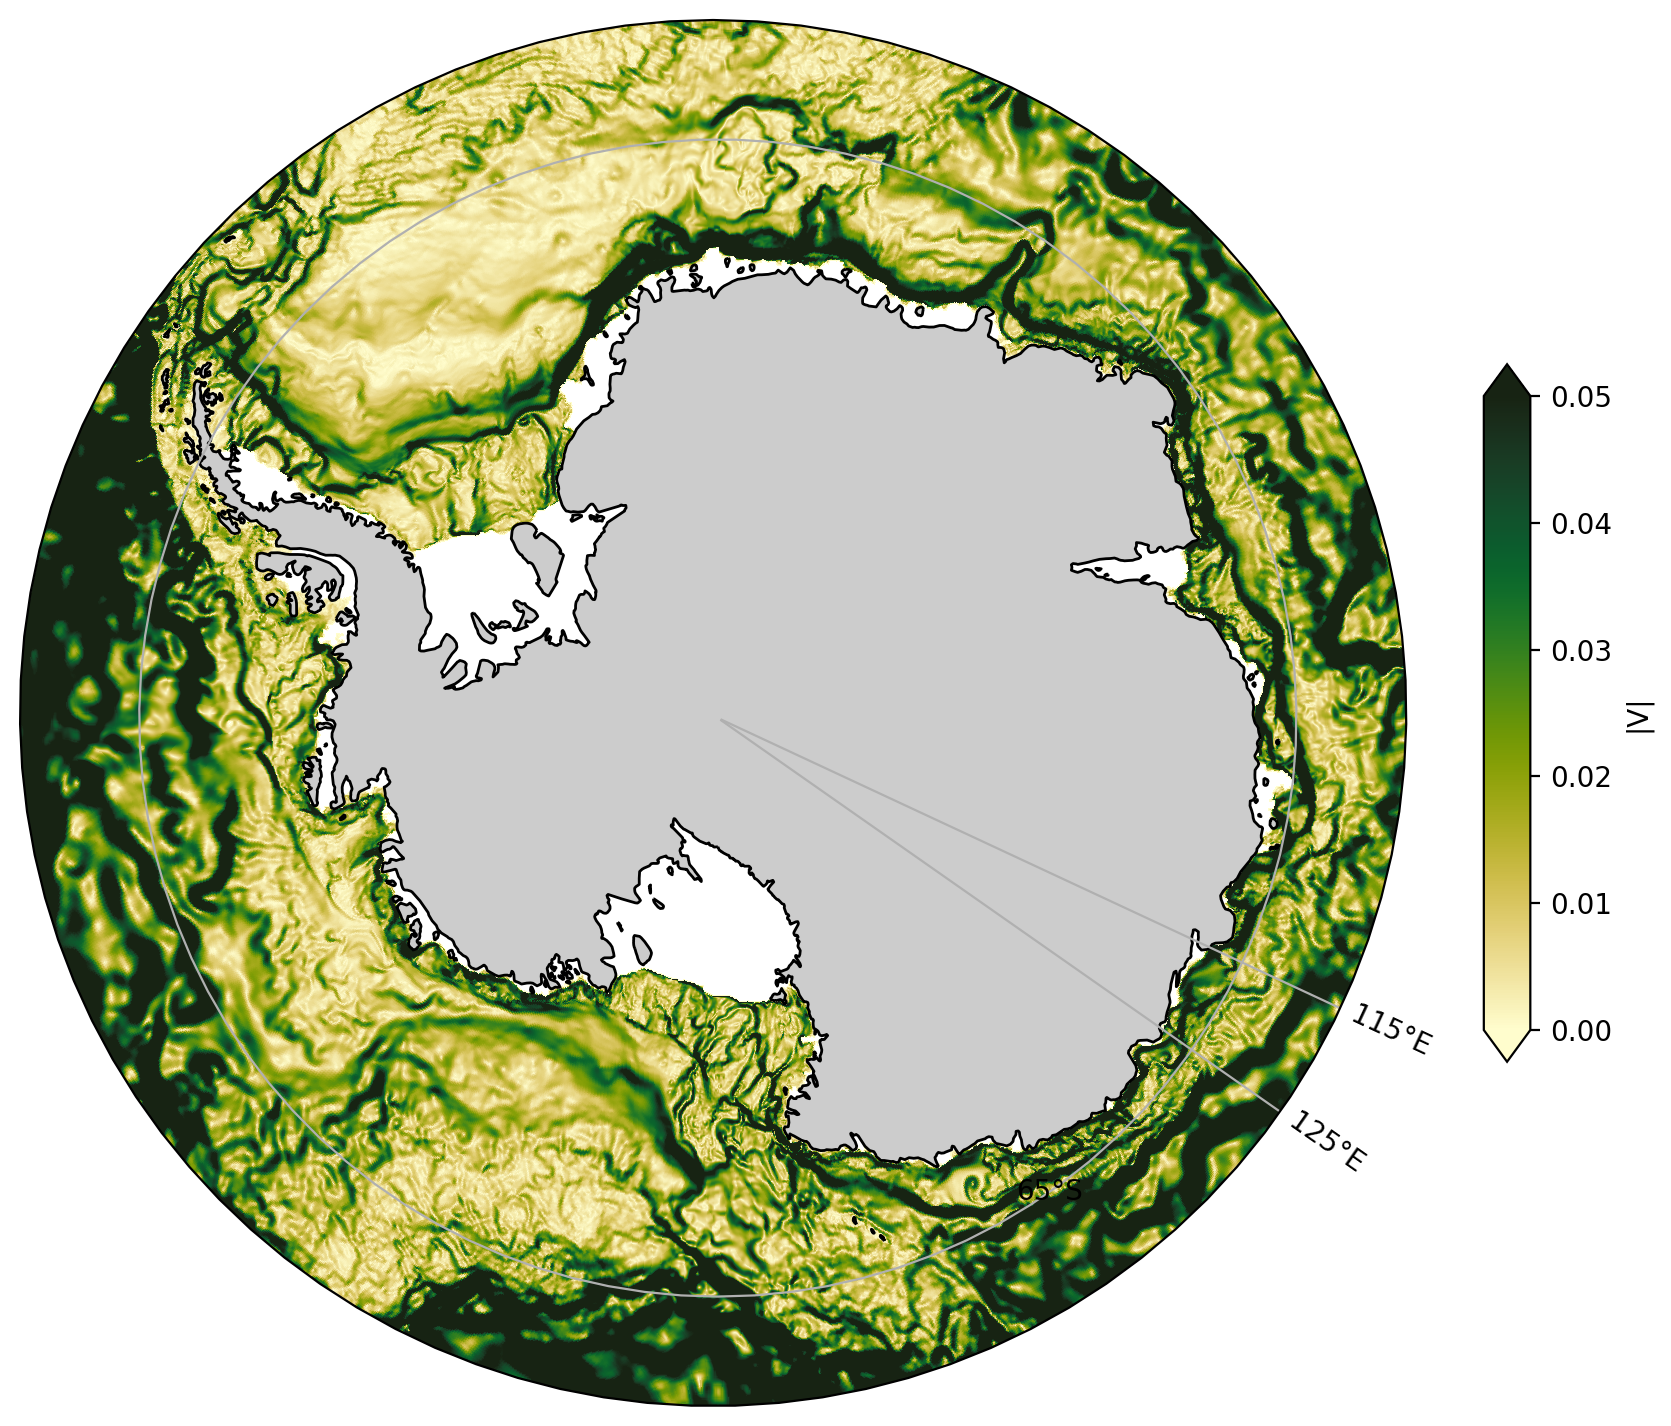

In [11]:
projection = ccrs.SouthPolarStereo()

import matplotlib.path as mpath
import cartopy.feature as cft

land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='papayawhip', linewidth=0.5)

plt.figure(figsize=(10, 9))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')
ax.gridlines(draw_labels=True,ylocs=[-65,-60],xlocs=[125,115])

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

V.plot(x='xt_ocean', y='yt_ocean',
         transform=ccrs.PlateCarree(),
         vmin=0, vmax=.05, extend='both',
         cmap=cm.cm.speed,
         cbar_kwargs = {'label': '|V|',
                        'fraction': 0.03,
                        'aspect': 15,
                        'shrink': 0.7});

In [12]:
UVELmeanz2 = UVELmeanz.sel({'xt_ocean': slice(-246, -237)}).mean('xt_ocean').compute()
UVELmeanz2 = UVELmeanz2.compute()
humean=hu.sel({'xu_ocean': slice(-246, -237)}).mean('xu_ocean').compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, 'Totten Ice Shelf')

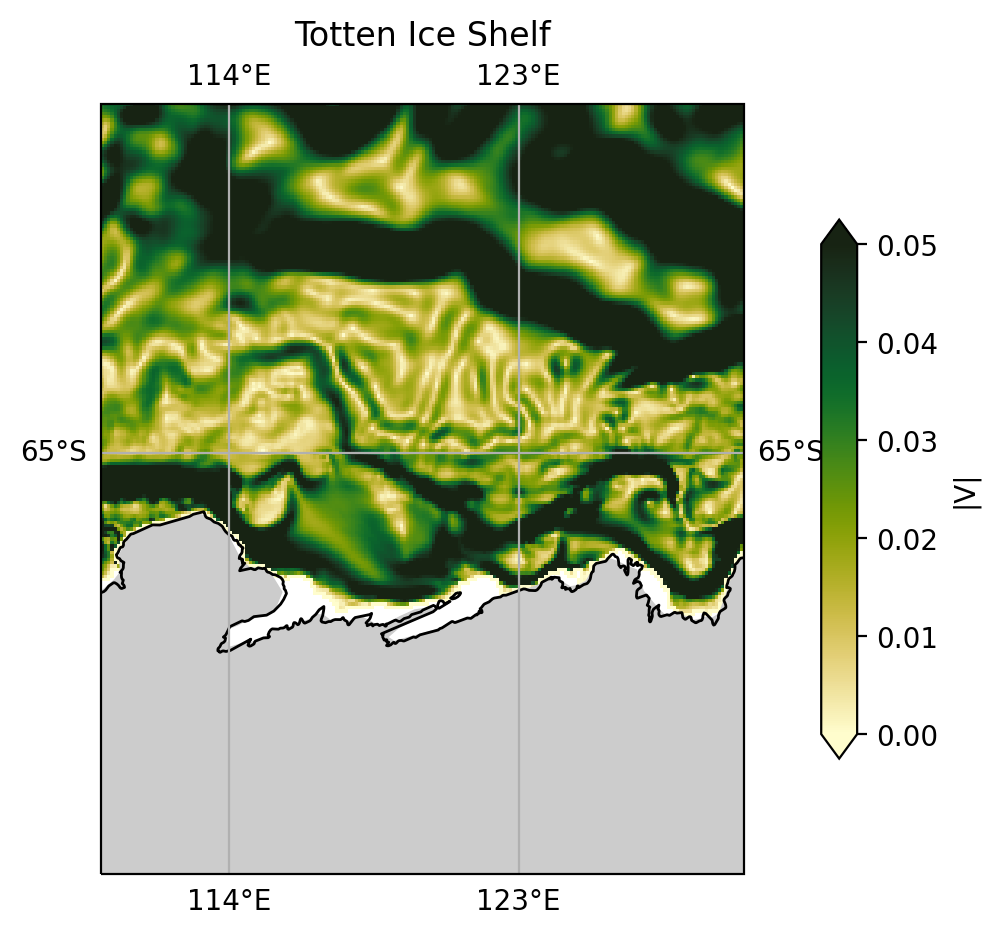

In [13]:
projection = ccrs.Mercator(central_longitude=120, min_latitude=-80.0, max_latitude=-55)

plt.figure(figsize=(10, 5))
ax = plt.axes(projection=projection)

ax.set_extent([110, 130, -70, -60], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True,ylocs=[-65],xlocs=[123,114])
V.plot(x='xt_ocean', y='yt_ocean',
         transform=ccrs.PlateCarree(),
         vmin=0, vmax=.05, extend='both',
         cmap=cm.cm.speed,
         cbar_kwargs = {'label': '|V|',
                        'fraction': 0.03,
                        'aspect': 15,
                        'shrink': 0.7});
plt.title('Totten Ice Shelf')

In [14]:
humean.isel(yu_ocean=370)
#By looking at the location od the 1000m bathymetry, it seems to me that ASC is mostly enclosed between [65.4S 64.7S]. 
#So I will just use the value of U at the 100m bathymetry location.

<xarray.DataArray 'hu' ()>
array(947.2298, dtype=float32)
Coordinates:
    yu_ocean  float64 -65.46

Text(0.5, 1.0, 'Totten Ice Shelf')

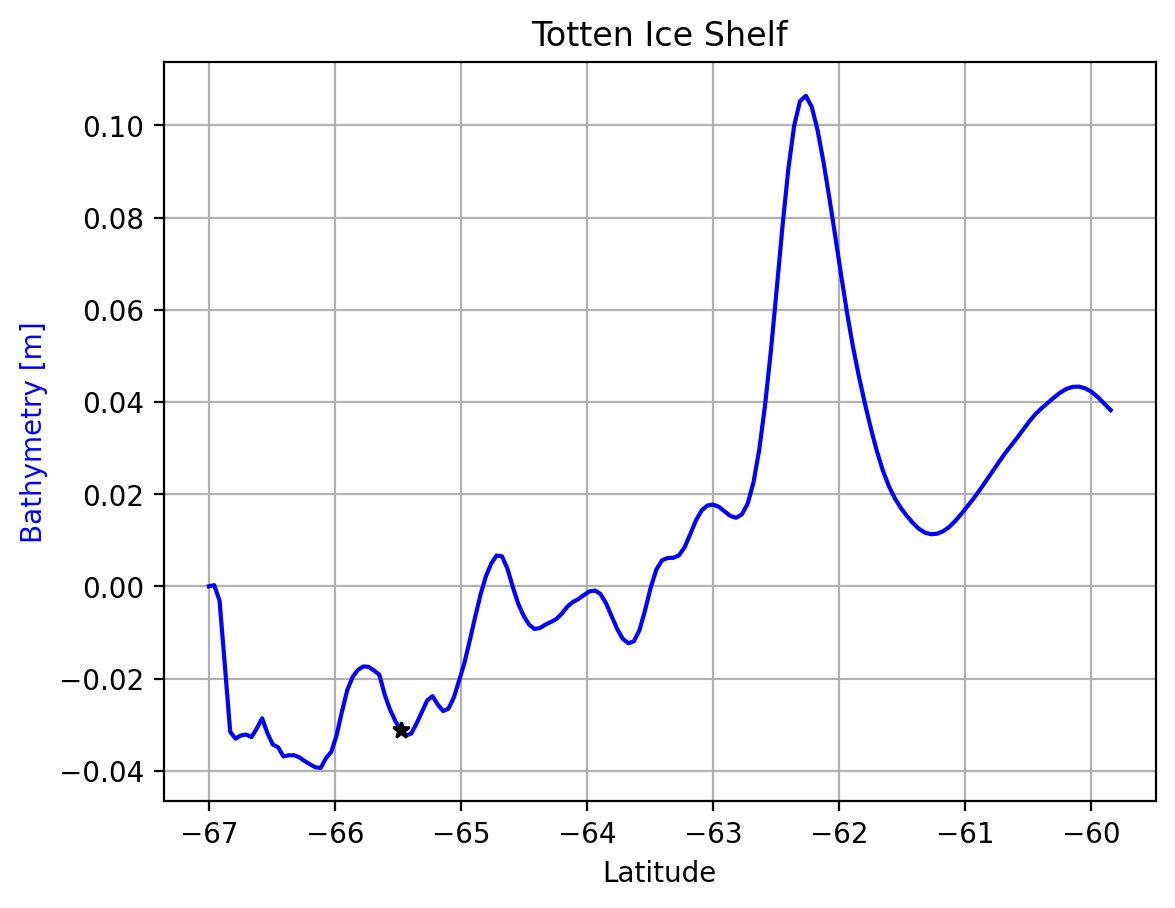

In [15]:
#maximum negative speed seem to be ~67S. but South of 64S, all zonal speed seems negative (ASC)

fig, ax1 = plt.subplots()
#ax2 = ax1.twinx()
#Batrhymetry
ax1.plot(UVELmeanz2['yt_ocean'], UVELmeanz2, 'b-')
ax1.plot(UVELmeanz2['yt_ocean'].sel(yt_ocean=-65.46, method='nearest'), UVELmeanz2.sel(yt_ocean=-65.46, method='nearest'), 'k*')
ax1.set_xlabel('Latitude')
ax1.grid()
#Uvel
#ax2.plot(UVELmeanz2['yt_ocean'],UVELmeanz2, 'g-')
#ax2.grid()


ax1.set_ylabel('Bathymetry [m]', color='b')
plt.title('Totten Ice Shelf')

Text(0.5, 1.0, 'Amery Ice Shelf')

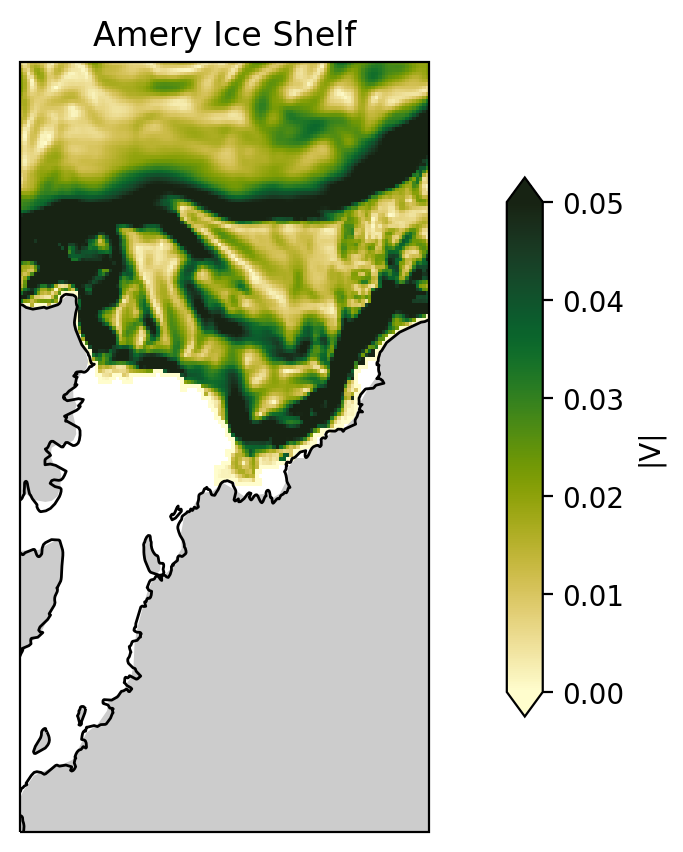

In [16]:
projection = ccrs.Mercator(central_longitude=72, min_latitude=-80.0, max_latitude=-55)

plt.figure(figsize=(10, 5))
ax = plt.axes(projection=projection)

ax.set_extent([80, 68, -73, -65], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True,ylocs=[-65],xlocs=[123,114])
V.plot(x='xt_ocean', y='yt_ocean',
         transform=ccrs.PlateCarree(),
         vmin=0, vmax=.05, extend='both',
         cmap=cm.cm.speed,
         cbar_kwargs = {'label': '|V|',
                        'fraction': 0.03,
                        'aspect': 15,
                        'shrink': 0.7});
plt.title('Amery Ice Shelf')

In [21]:
UVELmeanza = UVELmeanz.sel({'xt_ocean': slice(68, 80)}).mean('xt_ocean').compute()
UVELmeanza = UVELmeanza.compute()
humeana=hu.sel({'xu_ocean': slice(68, 80)}).mean('xu_ocean').compute()
UVELmeanza

<xarray.DataArray (yt_ocean: 494)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
...
        0.00573622,  0.00478596,  0.00474787,  0.00595065,  0.00844328,
        0.01212337,  0.01654583,  0.02127304,  0.02619272,  0.03131711,
        0.03654865,  0.04168971,  0.04656911,  0.05113925,  0.05531363,
        0.05884024,  0.06150353,  0.06323608,  0.06402033,  0.06364725,
        0.06165775,  0.05787548,  0.05272905,  0.04690785,  0.041073  ,
        0.03583776,  0.0316984 ,  0.02888454,  0.02717664,  0.0261054 ,
        0.02540582,  0.02512343,  0.02534049,  0.02596257,  0.02680195,
        0.0276059 ,  0.02818211,  0.02846219,  0.02842339,  0.02821996,
        0.02827898,  0.02901069,  0.03045318,  0.0324321 ,  0.03467295,
        0.03678435,  0.03848659,  0.03967369,  0.04025218,  0.04014475,
        0.03933366,  0.0378934 ,  0.03609784,  0.03434045,  0.0329163 ,
        0.03179246,  0.03072687,  0.02965948,  0.02877675,  0.02835078,
        0.02861531,  0.02966511,  0.03144141,  0.0338293 ,  0.03665679,
        0.0397227 ,  0.04291917,  0.04618353,  0.04936345,  0.05215869,
        0.05418376,  0.05519729,  0.05519961,  0.05429215,  0.05263756,
        0.05043882,  0.04790181,  0.04514196,  0.04218127,  0.03910226,
        0.03606764,  0.03322522,  0.03060624,  0.02817399,  0.0259659 ,
        0.02411177,  0.02268522,  0.02154784,  0.02045616,  0.01920009,
        0.01758547,  0.01544405,  0.01268722,  0.00949176,  0.00634453,
        0.00369604,  0.00170005,  0.00029457, -0.00056527], dtype=float32)
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -59.95 -59.9 -59.85

In [22]:
humeana.isel(yu_ocean=339)

<xarray.DataArray 'hu' ()>
array(1028.2766, dtype=float32)
Coordinates:
    yu_ocean  float64 -66.77

Text(0.5, 1.0, 'Amery Ice Shelf')

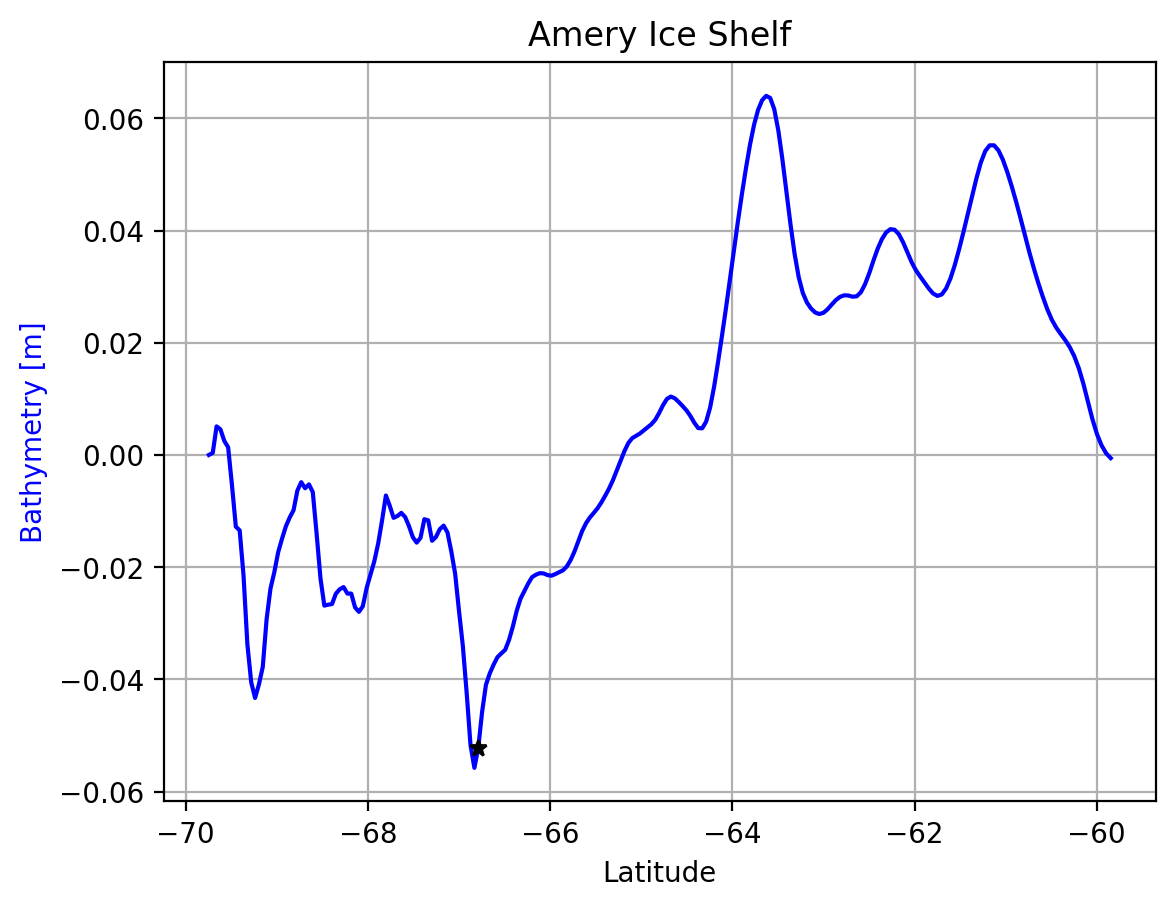

In [27]:
#maximum negative speed seem to be ~67S. but South of 64S, all zonal speed seems negative (ASC)

fig, ax1 = plt.subplots()
#ax2 = ax1.twinx()
#Batrhymetry
ax1.plot(UVELmeanza['yt_ocean'], UVELmeanza, 'b-')
ax1.plot(UVELmeanza['yt_ocean'].sel(yt_ocean=-66.77, method='nearest'), UVELmeanza.sel(yt_ocean=-66.77, method='nearest'), 'k*')
ax1.set_xlabel('Latitude')
ax1.grid()



ax1.set_ylabel('Bathymetry [m]', color='b')
plt.title('Amery Ice Shelf')